In [1]:
import numpy as np
import sys
import glob
import pickle
import pandas as pd
import pyccl as ccl
from mpl_toolkits import axes_grid1
import matplotlib.pyplot as plt

In [33]:
%load_ext autoreload
%autoreload 2
sys.path.append('../modules/')
import abundance as cl_count
import covariance as covar
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
sys.path.append('/pbs/throng/lsst/users/cpayerne/PySSC/')
import PySSC

In [65]:
n_logm_bin =10
n_z_bin =4
logm_corner = np.linspace(11, 13, n_logm_bin + 1)
logMass_bin = binning(logm_corner)
z_corner = np.linspace(0.001,2, n_z_bin + 1)
Z_bin = binning(z_corner)

# Covariance Matrix Prediction (CCL + PySSC from F.Lacasa et al.)

## Fiducial cosmology (CCL)

In [66]:
Omega_c_true = 0.30711 - 0.048254
Omega_b_true = 0.048254
sigma8_true = .8288
Omegam_true = 0.30711
True_value = [Omega_c_true + Omega_b_true, sigma8_true]
cosmo = ccl.Cosmology(Omega_c = Omega_c_true, Omega_b = Omega_b_true, h = 0.6777, sigma8 = sigma8_true, n_s=0.96)

## Abundance (CCL)

In [80]:
(360**2/np.pi)

41252.96124941927

In [67]:
clc = cl_count.ClusterAbundance()
#choose the halo mass function and mass definition
massdef = ccl.halos.massdef.MassDef('vir', 'critical', c_m_relation=None)
hmd = ccl.halos.hmfunc.MassFuncDespali16(cosmo, mass_def=massdef)
halobias = ccl.halos.hbias.HaloBiasTinker10(cosmo, mass_def= massdef, mass_def_strict=True)
clc.set_cosmology(cosmo = cosmo, hmd = hmd, massdef = massdef)
clc.sky_area = (1400/(360**2/np.pi)) * 4 * np.pi
clc.f_sky = clc.sky_area/(4*np.pi)
z_grid = np.linspace(0.0001, 2.01, 2000)
logm_grid = np.linspace(10.99, 13.001, 2001)
clc.compute_multiplicity_grid_MZ(z_grid = z_grid, logm_grid = logm_grid)
Abundance = clc.Cluster_Abundance_MZ(Redshift_bin = Z_bin, Proxy_bin = logMass_bin, method = 'simps')
clc.compute_halo_bias_grid_MZ(z_grid = z_corner, logm_grid = logm_corner, halobiais = halobias)
NHalo_bias = clc.Nhalo_bias_MZ(Redshift_bin = Z_bin, Proxy_bin = logMass_bin, method = 'simps')

## Matter amplitude fluctuation (PySSC)

In [68]:
Covariance = covar.Covariance_matrix()
#use PySSC from Lacasa et al.
Sij = Covariance.matter_fluctuation_amplitude_fullsky(Z_bin)

## Sample covariance (CCL + pySSC)

In [69]:
Sample_covariance = Covariance.sample_covariance_full_sky(Z_bin, logMass_bin, NHalo_bias, Sij)/clc.f_sky

top


In [76]:
Covariance_prediction = Sample_covariance + np.diag(Abundance.flatten())

In [84]:
t = {}
t['Log10MASS BINS'] = logMass_bin
t['REDSHIFT BINS'] = Z_bin
t['SAMPLE COVARIANCE'] = Sample_covariance
t['ABUNDANCE'] = Abundance
t['FULL COVARIANCE'] = Covariance_prediction

In [86]:

def save_pickle(dat, filename, **kwargs):
    file = open(filename,'wb')
    pickle.dump(dat, file)
    file.close()

In [87]:
save_pickle(t, 'covariance_Murray.pkl')

In [77]:
def corr(C1, C2):
    res=np.zeros([C1.shape[0],C1.shape[1]])
    for i in range(C1.shape[0]):
        for j in range(C1.shape[0]):
            res[i,j]=C1[i,j]/np.sqrt(C2[i,i]*C2[j,j])
    return res

In [78]:
c1=corr(Covariance_prediction-np.diag(Abundance.flatten()), 
                np.diag(Abundance.flatten()))
plot=np.zeros([c1.shape[0], c1.shape[1]])
for i in range(c1.shape[0]):
    for j in range(c1.shape[1]):
        #if i >= j:
        #    plot[i,j]=Covariance_estimation[i,j]/np.sqrt(Covariance_estimation[i,i]*Covariance_estimation[j,j])
        plot[i,j]=Covariance_prediction[i,j]/np.sqrt(Covariance_prediction[i,i]*Covariance_prediction[j,j])

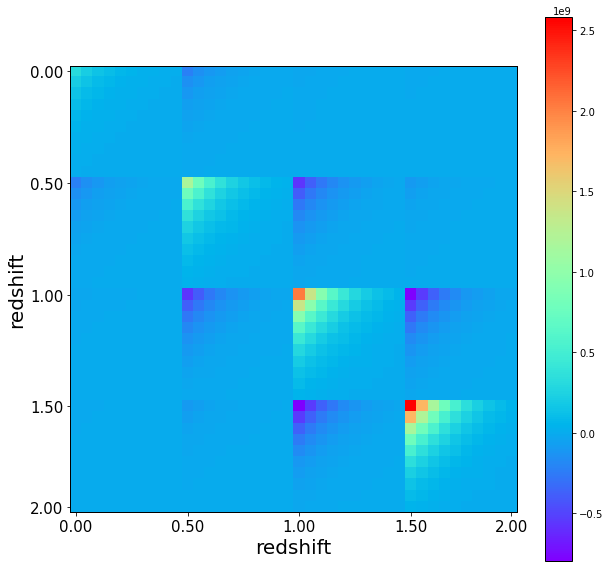

In [79]:
plt.figure(figsize=(10,10))
plt.rcParams['axes.linewidth']= 1
plt.tick_params(axis='both', which = 'major', labelsize= 15)
im=plt.imshow(Covariance_prediction, 
           #vmin=-1, vmax=1, 
           cmap='rainbow', )
              #origin='lower')
x = np.arange(len(Sample_covariance[:,1]))
#plt.plot(x,x,'k')
z_ticks = [f'{z:.2f}' for z in z_corner]
index = np.arange((len(Z_bin))*(len(logMass_bin)))
index_split = np.split(index, len(Z_bin))
ticks = [index_split[i][0] for i in range(len(Z_bin))]
ticks.append(len(Z_bin)*len(logMass_bin) - 1)
plt.xticks(ticks=ticks, labels=z_ticks)
plt.yticks(ticks=ticks, labels=z_ticks)
plt.xlabel('redshift', fontsize = 20)
plt.ylabel('redshift', fontsize = 20)
plt.grid(True, which='minor')
plt.grid(True, which='minor')
#fig.colorbar(im,)
plt.colorbar()
plt.savefig('cov_calum.pdf', bbox_inches='tight', dpi=300)

In [74]:
beta = (1000-20*30-2)/(1000-1)
plt.plot(count_mean.flatten(), 100*(Covariance_estimation.diagonal()-Covariance_prediction.diagonal())/Covariance_prediction.diagonal(), 'xk')
#plt.plot(count_mean.flatten(), 0*(Covariance_estimation.diagonal()-Covariance_prediction.diagonal())/Covariance_prediction.diagonal(), '-k', linewidth=1)
plt.xscale('log')
plt.xlabel('N', fontsize=20)
plt.ylabel('|bias| (%)', fontsize=20)
#plt.savefig('bias_sigma.pdf', bbox_inches='tight', dpi=300)

NameError: name 'count_mean' is not defined